In [176]:
import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
from scipy.sparse.linalg import eigs

from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvnpdf
import cvxpy as cp
import time
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from numpy.matlib import repmat
import scipy.sparse as sp
import jax.numpy as jnp

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv

import numpy as np
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import numpy as np
from scipy.spatial.distance import squareform
from sklearn.metrics import precision_score, recall_score, f1_score, normalized_mutual_info_score

In [177]:


def graph_learning_perf_eval(L_0, L):
    """
    Evaluates the performance of a learned graph by comparing it with the ground truth Laplacian matrix.

    Parameters:
    -----------
    L_0 : np.ndarray
        Ground truth Laplacian matrix of shape (n, n).
    
    L : np.ndarray
        Learned Laplacian matrix of shape (n, n).

    Returns:
    --------
    precision : float
        Precision score of the learned graph.
    
    recall : float
        Recall score of the learned graph.
    
    f : float
        F1 score of the learned graph.
    
    NMI_score : float
        Normalized Mutual Information score of the learned graph.
    
    num_of_edges : int
        Number of edges in the learned graph.
    """
    # Edges in the ground truth graph
    L_0tmp = L_0 - np.diag(np.diag(L_0))
    L_0tmp = (L_0tmp + L_0tmp.T) / 2  
    edges_groundtruth = squareform(L_0tmp) != 0

    # Edges in the learned graph
    Ltmp = L - np.diag(np.diag(L))
    Ltmp = (Ltmp + Ltmp.T) / 2  
    edges_learned = squareform(Ltmp) != 0

    # Compute precision, recall, F1-score
    precision = precision_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)
    recall = recall_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)
    f = f1_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)

    # NMI
    NMI_score = normalized_mutual_info_score(edges_learned.astype(int), edges_groundtruth.astype(int))
    if np.isnan(NMI_score):
        NMI_score = 0

    # Number of edges in the learned graph
    num_of_edges = np.sum(edges_learned)

    return precision, recall, f, NMI_score, num_of_edges


import numpy as np

def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
    """
    Identifies and compares clusters based on given Laplacian matrices and cluster assignments.

    Parameters:
    -----------
    Ls : np.ndarray
        Estimated Laplacian matrices of shape (n, n, k).
    
    Lap : np.ndarray
        Ground truth Laplacian matrices of shape (n, n, k).
    
    gamma_hats : np.ndarray
        Estimated cluster assignments of shape (m, k).
    
    gamma_cut : np.ndarray
        Ground truth cluster assignments of shape (m, k).
    
    k : int
        Number of clusters.

    Returns:
    --------
    identify : np.ndarray
        Indices of the identified clusters of shape (k,).
    
    precision : np.ndarray
        Precision scores for each cluster of shape (k,).
    
    recall : np.ndarray
        Recall scores for each cluster of shape (k,).
    
    f : np.ndarray
        F1 scores for each cluster of shape (k,).
    
    cl_errors : np.ndarray
        Clustering errors for each cluster of shape (k,).
    
    NMI_score : np.ndarray
        Normalized Mutual Information scores for each cluster of shape (k,).
    
    num_of_edges : np.ndarray
        Number of edges for each cluster of shape (k,).
    """
    identify = np.zeros(k, dtype=int)
    cl_err = np.inf * np.ones(k)
    precision = np.zeros(k)
    recall = np.zeros(k)
    f = np.zeros(k)
    NMI_score = np.zeros(k)
    num_of_edges = np.zeros(k)

    for i in range(k):
        W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
        W[W < 0.001] = 0
        Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
        for j in range(k):
            er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j])
            if cl_err[i] > er:
                cl_err[i] = er
                identify[i] = j

    for i in range(k):
        idx = identify[i]
        precision[i], recall[i], f[i], NMI_score[i], num_of_edges[i] = graph_learning_perf_eval(Lap[:, :, idx], Ls[:, :, i])

    # Compute clustering errors
    cl_errors = np.array([np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, identify[i]]) for i in range(k)])

    return identify, precision, recall, f, cl_errors, NMI_score, num_of_edges



def generate_connected_graph(n, p, zero_thresh):
    """
    Generates a connected Erdos-Renyi graph and returns its Laplacian matrix.

    Parameters:
    -----------
    n : int
        Number of nodes in the graph.
    
    p : float
        Probability for edge creation in the Erdos-Renyi graph.
    
    zero_thresh : float
        Threshold for the second smallest eigenvalue of the Laplacian matrix
        to ensure graph connectivity.

    Returns:
    --------
    np.ndarray
        Laplacian matrix of the generated connected graph.
    """
    while True:
        g = nx.erdos_renyi_graph(n, p)
        L = nx.laplacian_matrix(g).toarray()
        eigs = np.sort(eigvals(L))
        if eigs[1] > zero_thresh:
            return L

In [178]:

def squareform_sp(w):
    """
    Sparse counterpart of numpy's squareform
    
    Parameters:
    w : sparse vector with n(n-1)/2 elements OR matrix with size [n, n] and zero diagonal
    
    Returns:
    W : matrix form of input vector w OR vector form of input matrix W
    """
    # If input is not sparse, check density
    if not sp.issparse(w):
        density = np.count_nonzero(w) / w.size
        if density > 1/10:
            # Use standard squareform for non-sparse data
            return squareform(w)
        else:
            # Proceed with the function using NumPy arrays
            pass
    
    if w.ndim == 1 or w.shape[0] == 1 or w.shape[1] == 1:  # It's a vector
        # VECTOR -> MATRIX
        l = w.size
        n = int(round((1 + np.sqrt(1 + 8*l)) / 2))
        
        # Check input
        if l != n*(n-1)//2:
            raise ValueError("Bad vector size!")
        
        ind_vec = w.nonzero()[0]
        s = w[ind_vec]
        num_nz = len(ind_vec)
        
        ind_i = np.zeros(num_nz, dtype=int)
        ind_j = np.zeros(num_nz, dtype=int)
        
        curr_row = 0
        offset = 0
        len_row = n - 1
        for idx in range(num_nz):
            ind_vec_i = ind_vec[idx]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            ind_i[idx] = curr_row
            ind_j[idx] = ind_vec_i - offset + curr_row + 1
        
        # For the lower triangular part just add the transposed matrix
        data = np.concatenate([s, s])
        row_indices = np.concatenate([ind_i, ind_j])
        col_indices = np.concatenate([ind_j, ind_i])
        W = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
        return W

    else:
        # MATRIX -> VECTOR
        m, n = w.shape
        if m != n or not np.all(np.diagonal(w) == 0):
            raise ValueError("Matrix has to be square with zero diagonal!")
        
        ind_i, ind_j = w.nonzero()
        s = w[ind_i, ind_j]
        
        # Keep only upper triangular part
        ind_upper = ind_i < ind_j
        ind_i = ind_i[ind_upper]
        ind_j = ind_j[ind_upper]
        s = s[ind_upper]
        
        # Compute new (vector) index from (i,j) (matrix) indices
        new_ind = n * ind_i - ind_i * (ind_i + 1) // 2 + ind_j - ind_i - 1
        l = n * (n - 1) // 2
        w_vec = sp.csr_matrix((s, (new_ind, np.zeros_like(new_ind))), shape=(l, 1))
        return w_vec

def sum_squareform(n, mask=None):
    """
    Computes the sum and transpose sum matrices in a squareform format.

    Parameters:
    -----------
    n : int
        The size of the squareform matrix.
    
    mask : array-like, optional
        A mask to filter the indices. The length of the mask must be n(n-1)/2.
        If provided, only the elements corresponding to the non-zero values in
        the mask are considered.

    Returns:
    --------
    S : csr_matrix
        A sparse matrix of shape (n, n) representing the sum matrix.
    
    St : csr_matrix
        A sparse matrix of shape (n, n) representing the transpose sum matrix.

    Raises:
    -------
    ValueError
        If the length of the mask is not equal to n(n-1)/2.
    """
    if mask is not None:
        mask = np.asarray(mask).flatten()
        if len(mask) != n * (n - 1) // 2:
            raise ValueError('Mask size has to be n(n-1)/2')

        ind_vec = np.flatnonzero(mask)
        ncols = len(ind_vec)

        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        curr_row = 0
        offset = 0
        len_row = n - 1
        for ii in range(ncols):
            ind_vec_i = ind_vec[ii]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            I[ii] = curr_row
            J[ii] = ind_vec_i - offset + curr_row + 1

    else:
        ncols = (n * (n - 1)) // 2
        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        k = 0
        for i in range(n):
            for j in range(i + 1, n):
                I[k] = i
                J[k] = j
                k += 1

    St = csr_matrix((np.ones(ncols), (np.arange(ncols), I)), shape=(ncols, n))
    S = csr_matrix((np.ones(ncols), (np.arange(ncols), J)), shape=(ncols, n)).T + St.T

    return S, St


def normest(S):
    """
    Estimate the 2-norm (largest singular value) of a sparse matrix S.
    """
    u, s, vt = svds(S, k=1)
    return s[0]


## corect one
def prox_sum_log(x, gamma, param=None):
    """
    Proximal operator of log-barrier - sum(log(x))
    
    Parameters:
    x : Input signal (vector or matrix)
    gamma : Regularization parameter
    param : Dictionary of optional parameters
    
    Returns:
    sol : Solution
    info : Dictionary summarizing information at convergence
    """
    if param is None:
        param = {}
    
    verbose = param.get('verbose', 1)
    
    if gamma < 0:
        raise ValueError('Gamma cannot be negative')
    elif gamma == 0:
        stop_error = True
    else:
        stop_error = False
    
    t1 = time.time()
    
    if stop_error:
        sol = x
        info = {
            'algo': 'prox_sum_log',
            'iter': 0,
            'final_eval': 0,
            'crit': '--',
            'time': time.time() - t1
        }
        return sol, info
    
    sol = (x + np.sqrt(x**2 + 4*gamma)) / 2
    final_eval = -gamma * np.sum(np.log(x[x > 0]))  # Ignore non-positive elements for log
    
    info = {
        'algo': 'prox_sum_log',
        'iter': 0,
        'final_eval': final_eval,
        'crit': '--',
        'time': time.time() - t1
    }
    
    if verbose >= 1:
        print(f'  prox_sum_log: - sum(log(x)) = {info["final_eval"] / gamma:.6e}')
        if verbose > 1:
            n_neg = np.sum(x <= 0)
            if n_neg > 0:
                print(f' ({n_neg} negative elements, log not defined, check stability)')
        print()
    
    return sol, info

# def prox_sum_log(z, c, params):
#     x = (z - c) / 2 + np.sqrt(((z - c) / 2) ** 2 + c)
#     x = np.maximum(x, 1e-12)
#     return x

def lin_map(X, lims_out, lims_in=None):
    """
    Map linearly from a given range to another.

    Parameters:
    X : array-like
        Input array.
    lims_out : list or tuple
        Output limits [c, d].
    lims_in : list or tuple, optional
        Input limits [a, b]. If not specified, the minimum and maximum values of X are used.

    Returns:
    Y : array-like
        Linearly mapped output array.
    """
    X = np.asarray(X)
    
    if lims_in is None:
        lims_in = [np.min(X), np.max(X)]
    
    a, b = lims_in
    c, d = lims_out
    
    Y = (X - a) * ((d - c) / (b - a)) + c
    return Y

# def gsp_distanz(X, Y=None, P=None):
#     """
#     Calculates the distances between all vectors in X and Y using a provided matrix P for scaling (weighted distances).
    
#     Parameters:
#         X (numpy.ndarray): Matrix with column vectors of shape (n_features, n_samples_X).
#         Y (numpy.ndarray, optional): Matrix with column vectors of shape (n_features, n_samples_Y). Defaults to X.
#         P (numpy.ndarray, optional): Weight matrix of shape (n_features, n_features). Defaults to the identity matrix.

#     Returns:
#         numpy.ndarray: Distance matrix of shape (n_samples_X, n_samples_Y), not squared.
        
#     Raises:
#         ValueError: If the dimensions of X and Y do not match.
#         ValueError: If the dimensions of P do not match the number of features in X.

#     Usage:
#         D = gsp_distanz(X, Y, P)
        
#     Notes:
#         This function computes the following:
        
#             D = sqrt((X - Y)^T P (X - Y))
        
#         for all vectors in X and Y. If P is not provided, it defaults to the identity matrix, reducing the calculation to the Euclidean distance.
#         The function is optimized for speed using vectorized operations, avoiding explicit loops.
#     """
    
#     if Y is None:
#         Y = X
    
#     if X.shape[0] != Y.shape[0]:
#         raise ValueError("The sizes of X and Y do not match!")

#     n_features, n_samples_X = X.shape
#     _, n_samples_Y = Y.shape
    
#     if P is None:
#         xx = np.sum(X**2, axis=0)  # ||x||^2
#         yy = np.sum(Y**2, axis=0)  # ||y||^2
#         xy = X.T @ Y  # <y,x>
#         D = np.abs(np.add.outer(xx, yy) - 2 * xy)
#     else:
#         rp, rp2 = P.shape
#         if n_features != rp or rp != rp2:
#             raise ValueError("P must be square and match the dimension of X!")

#         xx = np.sum(X * (P @ X), axis=0)  # x^T P x
#         yy = np.sum(Y * (P @ Y), axis=0)  # y^T P y
#         xy = X.T @ (P @ Y)  # x^T P y
#         D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    
#     if np.any(D < 0):
#         print('Warning: P is not semipositive or x is not real!')

#     D = np.sqrt(D)
    
#     if Y is X:
#         np.fill_diagonal(D, 0)

#     return D

def gsp_distanz(X, Y=None, P=None):
    """
    Calculates the distances between all vectors in X and Y using a provided matrix P for scaling (weighted distances).
    
    Parameters:
        X (numpy.ndarray): Matrix with column vectors of shape (n_features, n_samples_X).
        Y (numpy.ndarray, optional): Matrix with column vectors of shape (n_features, n_samples_Y). Defaults to X.
        P (numpy.ndarray, optional): Weight matrix of shape (n_features, n_features). Defaults to the identity matrix.

    Returns:
        numpy.ndarray: Distance matrix of shape (n_samples_X, n_samples_Y), not squared.
        
    Raises:
        ValueError: If the dimensions of X and Y do not match.
        ValueError: If the dimensions of P do not match the number of features in X.

    Usage:
        D = gsp_distanz(X, Y, P)
        
    Notes:
        This function computes the following:
        
            D_{ij} = sqrt( (X_i - Y_j)^T P (X_i - Y_j) )
        
        for all vectors in X and Y. If P is not provided, it defaults to the identity matrix, reducing the calculation to the Euclidean distance.
        The function is optimized for speed using vectorized operations, avoiding explicit loops.
    """
    import numpy as np
    
    if Y is None:
        Y = X
    
    if X.shape[0] != Y.shape[0]:
        raise ValueError("The sizes of X and Y do not match!")

    n_features, n_samples_X = X.shape
    _, n_samples_Y = Y.shape
    
    if P is None:
        xx = np.sum(X**2, axis=0)  # ||x||^2, shape (n_samples_X,)
        yy = np.sum(Y**2, axis=0)  # ||y||^2, shape (n_samples_Y,)
        xy = X.T @ Y               # Inner products, shape (n_samples_X, n_samples_Y)
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    else:
        rp, rp2 = P.shape
        if n_features != rp or rp != rp2:
            raise ValueError("P must be square and match the dimension of X!")

        xx = np.sum(X * (P @ X), axis=0)  # x^T P x, shape (n_samples_X,)
        yy = np.sum(Y * (P @ Y), axis=0)  # y^T P y, shape (n_samples_Y,)
        xy = X.T @ (P @ Y)                # x^T P y, shape (n_samples_X, n_samples_Y)
        yx = Y.T @ (P @ X)                # y^T P x, shape (n_samples_Y, n_samples_X)
        D = np.abs(np.add.outer(xx, yy) - xy - yx.T)  # Subtract yx.T to match dimensions

    if np.any(D < 0):
        print('Warning: P is not semipositive or x is not real!')

    D = np.sqrt(D)
    
    if Y is X:
        np.fill_diagonal(D, 0)

    return D


# Example usage
def generate_example_data(n=256):
    G_coords = np.random.rand(n, 2)
    f1 = lambda x, y: np.sin((2 - x - y) ** 2)
    f2 = lambda x, y: np.cos((x + y) ** 2)
    f3 = lambda x, y: (x - 0.5) ** 2 + (y - 0.5) ** 3 + x - y
    f4 = lambda x, y: np.sin(3 * ((x - 0.5) ** 2 + (y - 0.5) ** 2))
    X = np.vstack([f1(G_coords[:, 0], G_coords[:, 1]),
                   f2(G_coords[:, 0], G_coords[:, 1]),
                   f3(G_coords[:, 0], G_coords[:, 1]),
                   f4(G_coords[:, 0], G_coords[:, 1])]).T
    return G_coords, X


def visualize_glmm(Ls, gamma_hats):
    k = gamma_hats.shape[1]
    n = Ls.shape[0]
    
    G = nx.Graph()
    
    for i in range(n):
        G.add_node(i)
    
    for l in range(k):
        L = Ls[:, :, l]
        for i in range(n):
            for j in range(i+1, n):
                if L[i, j] != 0:
                    G.add_edge(i, j, weight=L[i, j])
    
    colors = []
    for i in range(n):
        cluster = np.argmax(gamma_hats[i])
        colors.append(cluster)
    
    pos = nx.spring_layout(G)  
    
    nx.draw_networkx_nodes(G, pos, node_size=700, cmap=plt.cm.RdYlBu, node_color=colors)
    
    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    
    plt.title('Graph Laplacian Mixture Model (GLMM) Visualization')
    plt.show()
    
    


# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix.

#     a : float
#         Coefficient for the logarithmic penalty term.

#     b : float
#         Regularization coefficient.

#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'W_init': Initial weight matrix (default: zeros)
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'c': float, regularization coefficient for initial weight matrix
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix.

#     stat : dict
#         Optional output statistics.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     # Default parameters
#     if params is None:
#         params = {}

#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     # Initialize z
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z.copy()
#     else:
#         z = squareform_sp(Z)

#     z = z.flatten()
#     l = len(z)
#     n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

#     # Handle w_0
#     if not np.isscalar(w_0) or w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0.copy()
#         else:
#             w_0 = squareform_sp(w_0)
#         w_0 = w_0.flatten()
#     else:
#         w_0 = 0

#     # Handle fix_zeros
#     if fix_zeros:
#         if 'edge_mask' not in params:
#             raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
#         edge_mask = params['edge_mask']
#         if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
#             edge_mask = squareform_sp(edge_mask)
#         ind = np.nonzero(edge_mask.flatten())[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     # Initialize w
#     w = np.zeros_like(z)

#     # Needed operators
#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = normest(S)
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     # Define functions f, g, h
#     f_eval = lambda w: 2 * np.dot(w, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda s: -a * np.sum(np.log(s))
#     g_prox = lambda s, c: prox_sum_log(s, c * a, param_prox_log)[0]
#     g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]

#     if np.all(w_0 == 0):
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2
#         h_grad = lambda w: 2 * b * w
#         h_beta = 2 * b
#     else:
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
#         h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
#         h_beta = 2 * (b + c)

#     # Parameters for convergence
#     mu = h_beta + norm_K
#     epsilon = 1e-6  # A small positive value
#     gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

#     # Initialize variables
#     v_n = K_op(w)

#     stat = {}
#     if verbosity > 1:
#         stat['f_eval'] = []
#         stat['g_eval'] = []
#         stat['h_eval'] = []
#         stat['fgh_eval'] = []
#         stat['pos_violation'] = []

#     start_time = time.time()

#     # Iterative optimization
#     for i in range(maxit):
#         # Primal and dual updates
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         # Compute relative norms
#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

#         if verbosity > 1:
#             # Record statistics
#             stat['f_eval'].append(f_eval(w))
#             stat['g_eval'].append(g_eval(K_op(w)))
#             stat['h_eval'].append(h_eval(w))
#             stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
#             stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
#             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

#         # Update variables
#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         # Check convergence
#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     total_time = time.time() - start_time
#     if verbosity > 0:
#         print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {f_eval(w) + g_eval(K_op(w)) + h_eval(w):6.3e}')
#         print(f'Time needed is {total_time} seconds')

#     # Reconstruct full weight vector if fix_zeros was used
#     if fix_zeros:
#         w_full = np.zeros(l)
#         w_full[ind] = w
#         w = w_full

#     # Convert vectorized weights back to matrix form
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform_sp(w)

#     stat['time'] = total_time

#     return W, stat


# import numpy as np
# import time

# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix.

#     a : float
#         Coefficient for the logarithmic penalty term.

#     b : float
#         Regularization coefficient.

#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'W_init': Initial weight matrix (default: zeros)
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'c': float, regularization coefficient for initial weight matrix
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix.

#     stat : dict
#         Optional output statistics.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     # Import necessary libraries
#     import numpy as np
#     import time

#     # Default parameters
#     if params is None:
#         params = {}

#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     # Initialize z
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z.copy()
#     else:
#         z = squareform_sp(Z)  # You need to define or import squareform_sp

#     z = z.flatten()
#     l = len(z)
#     n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

#     # Handle w_0
#     if not np.isscalar(w_0) or w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0.copy()
#         else:
#             w_0 = squareform_sp(w_0)
#         w_0 = w_0.flatten()
#     else:
#         w_0 = 0
#         c = 0  # Ensure c is defined

#     # Handle fix_zeros
#     if fix_zeros:
#         if 'edge_mask' not in params:
#             raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
#         edge_mask = params['edge_mask']
#         if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
#             edge_mask = squareform_sp(edge_mask)
#         ind = np.nonzero(edge_mask.flatten())[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     # Initialize w
#     w = np.zeros_like(z)

#     # Needed operators
#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)  # You need to define or import sum_squareform
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = np.linalg.norm(S, ord=2)  # Approximate spectral norm
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     # Define functions f, g, h
#     f_eval = lambda w: 2 * np.dot(w, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     # Implement prox_sum_log function or import it
#     # prox_sum_log(s, c, params) should return the proximal operator of -a * sum(log(s))

#     g_eval = lambda s: -a * np.sum(np.log(s))
#     g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]

#     # Corrected h_eval and h_grad with division by 2
#     if np.all(w_0 == 0):
#         # No prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2
#         h_grad = lambda w: b * w
#         h_beta = b  # Lipschitz constant of h_grad
#     else:
#         # With prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2 + (c / 2) * np.linalg.norm(w - w_0) ** 2
#         h_grad = lambda w: b * w + c * (w - w_0)
#         h_beta = b + c  # Lipschitz constant of h_grad

#     # Parameters for convergence
#     mu = h_beta + norm_K
#     epsilon = 1e-6  # A small positive value
#     gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

#     # Initialize variables
#     v_n = K_op(w)

#     stat = {}
#     if verbosity > 1:
#         stat['f_eval'] = []
#         stat['g_eval'] = []
#         stat['h_eval'] = []
#         stat['fgh_eval'] = []
#         stat['pos_violation'] = []

#     start_time = time.time()

#     # Iterative optimization
#     for i in range(maxit):
#         # Primal and dual updates
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         # Compute relative norms
#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

#         if verbosity > 1:
#             # Record statistics
#             stat['f_eval'].append(f_eval(w))
#             stat['g_eval'].append(g_eval(K_op(w)))
#             stat['h_eval'].append(h_eval(w))
#             stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
#             stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
#             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

#         # Update variables
#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         # Check convergence
#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     total_time = time.time() - start_time
#     if verbosity > 0:
#         final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
#         print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
#         print(f'Time needed is {total_time} seconds')

#     # Reconstruct full weight vector if fix_zeros was used
#     if fix_zeros:
#         w_full = np.zeros(l)
#         w_full[ind] = w
#         w = w_full

#     # Convert vectorized weights back to matrix form
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform_sp(w)

#     stat['time'] = total_time

#     return W, stat
import numpy as np
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm as sparse_norm
from scipy.spatial.distance import squareform
from scipy.optimize import minimize_scalar

def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    """
    Learns a graph structure by optimizing a log-degrees model.

    Parameters:
    -----------
    Z : array-like
        Input data matrix or condensed distance matrix (squared pairwise distances).

    a : float
        Coefficient for the logarithmic penalty term (controls connectivity).

    b : float
        Regularization coefficient (controls sparsity).

    params : dict, optional
        A dictionary of optional parameters:
        - 'verbosity': int, level of verbosity (default: 1)
        - 'maxit': int, maximum number of iterations (default: 1000)
        - 'tol': float, tolerance for convergence (default: 1e-5)
        - 'step_size': float, step size for the gradient descent (default: 0.5)
        - 'max_w': float, maximum allowable weight (default: np.inf)
        - 'w_0': array-like or int, initial weight matrix or value (default: 0)
        - 'c': float, regularization coefficient for initial weight matrix
        - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
        - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

    Returns:
    --------
    W : array-like
        The learned weight matrix (n x n).

    stat : dict
        Output statistics including convergence information.

    Raises:
    -------
    ValueError
        If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
    """
    # Default parameters
    if params is None:
        params = {}

    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)
    w_0 = params.get('w_0', 0)

    # Initialize z
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z.copy()
    else:
        z = squareform_sp(Z)

    z = z.flatten()
    z = np.asarray(z, dtype=float)  # Ensure z is a NumPy array of floats
    l = len(z)
    n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

    # Handle w_0
    if not np.isscalar(w_0) or w_0 != 0:
        if 'c' not in params:
            raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
        else:
            c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0.copy()
        else:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.flatten()
        w_0 = np.asarray(w_0, dtype=float)
    else:
        w_0 = 0
        c = 0  # Ensure c is defined

    # Handle fix_zeros
    if fix_zeros:
        if 'edge_mask' not in params:
            raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
        edge_mask = params['edge_mask']
        if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
            edge_mask = squareform_sp(edge_mask)
        ind = np.nonzero(edge_mask.flatten())[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    # Initialize w
    w = np.zeros_like(z)

    # Needed operators
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w: S @ w
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = sparse_norm(S, ord=2)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    # Define functions f, g, h
    f_eval = lambda w: 2 * np.dot(w, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    g_eval = lambda s: -a * np.sum(np.log(s))
    # g_star_prox = lambda z_in, c_in: z_in - c_in * a * prox_sum_log(z_in / (c_in * a), 1 / (c_in * a), param_prox_log)
    # g_star_prox = lambda z_in, c_in: np.asarray(z_in) - c_in * a * prox_sum_log(np.asarray(z_in) / (c_in * a), 1 / (c_in * a), param_prox_log)
    g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]


    # Corrected h_eval and h_grad with division by 2
    if np.all(w_0 == 0):
        # No prior W0
        h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2
        h_grad = lambda w: b * w
        h_beta = b  # Lipschitz constant of h_grad
    else:
        # With prior W0
        h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2 + (c / 2) * np.linalg.norm(w - w_0) ** 2
        h_grad = lambda w: b * w + c * (w - w_0)
        h_beta = b + c  # Lipschitz constant of h_grad

    # Parameters for convergence
    mu = h_beta + norm_K
    epsilon = 1e-6  # A small positive value
    gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

    # Initialize variables
    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = []
        stat['g_eval'] = []
        stat['h_eval'] = []
        stat['fgh_eval'] = []
        stat['pos_violation'] = []

    start_time = time.time()

    # Iterative optimization
    for i in range(maxit):
        # Primal and dual updates
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        # Compute relative norms
        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

        if verbosity > 1:
            # Record statistics
            stat['f_eval'].append(f_eval(w))
            stat['g_eval'].append(g_eval(K_op(w)))
            stat['h_eval'].append(h_eval(w))
            stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
            stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
            print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

        # Update variables
        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        # Check convergence
        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    total_time = time.time() - start_time
    if verbosity > 0:
        final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
        print(f'Time needed is {total_time} seconds')

    # Reconstruct full weight vector if fix_zeros was used
    if fix_zeros:
        w_full = np.zeros(l)
        w_full[ind] = w
        w = w_full

    # Convert vectorized weights back to matrix form
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform(w)

    stat['time'] = total_time

    return W, stat


In [179]:


def glmm(y, iterations, classes, spread=0.1, regul=0.15, norm_par=1.5):
    """
    Implements a Graph Laplacian Mixture Model (GLMM) 

    Parameters:
    -----------
    y : np.ndarray
        The input data matrix of shape (m, n) where m is the number of signals
        and n is the number of features.
    
    iterations : int
        The number of iterations for the algorithm.
    
    classes : int
        The number of clusters (classes).
    
    spread : float, optional
        Spread parameter for initializing the Laplacian matrices (default: 0.1).
    
    regul : float, optional
        Regularization parameter for the covariance matrices (default: 0.15).
    
    norm_par : float, optional
        Normalization parameter for the distance computation (default: 1.5).

    Returns:
    --------
    L : np.ndarray
        The learned Laplacian matrices of shape (n, n, classes).
    
    gamma_hat : np.ndarray
        The cluster probabilities of shape (m, classes).
    
    mu : np.ndarray
        The cluster means of shape (n, classes).
    
    log_likelihood : np.ndarray
        The log-likelihood values over the iterations.

    Raises:
    -------
    ValueError
        If the dimensions of the input data are not correct.
    """
    
    delta = 2
    n = y.shape[1]
    m = y.shape[0]

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))
    log_likelihood = np.zeros(iterations)

    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - spread / n * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1 / classes

    # Start the algorithm
    for it in range(iterations):
        # Expectation step
        pall = 0
        for cls in range(classes):
            # vecl[:, :, cls], vall[:, :, cls] = eig(L[:, :, cls])
            eig_vals, eig_vecs = np.linalg.eig(L[:, :, cls])
            eig_vecs = np.real(eig_vecs)
            eig_vals = np.real(eig_vals)
            eig_vals[eig_vals < 0] = 1e-5
            vall[:, :, cls] = np.diag(eig_vals)
            vecl[:, :, cls] = eig_vecs
            sigma[:, :, cls] = inv(vall[1:n, 1:n, cls] + regul * np.eye(n-1))  
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2
            yl[:, :, cls] = (y - mu[:, cls].T) @ vecl[:, 1:n, cls]
            pall += p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls], allow_singular=True)

        # Compute cluster probabilities gamma_hat  
        pall[pall == 0] = 0.1
        for cls in range(classes):
            gamma_hat[:, cls] = (p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])) / pall

        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step: update mu, W, and p
        for cls in range(classes):
            mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])
            # yc = repmat(np.sqrt(gamma_hat[:, cls])[:, np.newaxis], 1, n) * (y - mu[:, cls])
            yc = np.sqrt(gamma_hat[:, cls])[:, np.newaxis] * (y - mu[:, cls])
            Z = gsp_distanz(yc) ** 2
            theta = np.mean(Z) / norm_par
            W_curr = delta * (gsp_learn_graph_log_degrees(Z / theta, 1, 1))[0]
            W[:, :, cls] = W_curr
            p[cls] = np.sum(gamma_hat[:, cls]) / m
            # Compute Ls
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]
            W_curr[W_curr < 1e-3] = 0
            W[:, :, cls] = W_curr

    return L, gamma_hat, mu, log_likelihood

#   mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])


# iters:  688. Rel primal: 0.0000e+00 Rel dual: 9.9262e-06  OBJ 1.706e+01
Time needed is 0.07642698287963867 seconds
# iters:  633. Rel primal: 4.8021e-08 Rel dual: 9.9455e-06  OBJ 1.674e+01
Time needed is 0.029384851455688477 seconds
# iters:  655. Rel primal: 4.1901e-16 Rel dual: 9.9498e-06  OBJ 1.683e+01
Time needed is 0.022156953811645508 seconds
# iters:  618. Rel primal: 1.1860e-07 Rel dual: 9.9231e-06  OBJ 1.629e+01
Time needed is 0.021355152130126953 seconds
# iters:  534. Rel primal: 6.1021e-11 Rel dual: 9.7782e-06  OBJ 1.643e+01
Time needed is 0.018249034881591797 seconds
# iters: 1000. Rel primal: 1.1466e-07 Rel dual: 1.5906e-05  OBJ 1.679e+01
Time needed is 0.03393888473510742 seconds
# iters:  790. Rel primal: 2.7151e-15 Rel dual: 9.8906e-06  OBJ 1.668e+01
Time needed is 0.02693796157836914 seconds
# iters: 1000. Rel primal: 1.1541e-07 Rel dual: 1.6690e-05  OBJ 1.649e+01
Time needed is 0.03393912315368652 seconds
# iters: 1000. Rel primal: 2.5571e-06 Rel dual: 1.6914e-05  

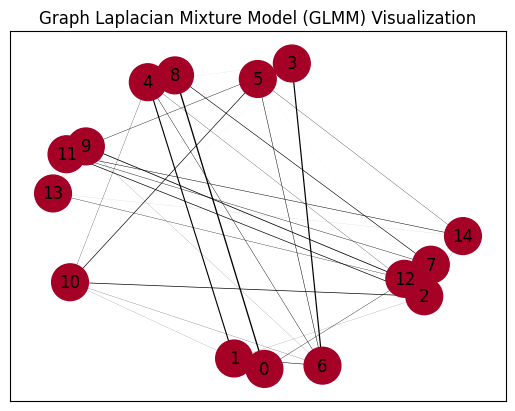

In [182]:

n = 15  
m = 150  
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k)
print('Training done')

print(np.sum(gamma_hats, axis=0))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)

In [189]:
import numpy as np
import networkx as nx
from scipy.linalg import pinv
from scipy.stats import multivariate_normal

# Parameters
n = 15  
m = 150  
k = 2
zero_thresh = 1e-4  # Threshold for second smallest eigenvalue
dist = 0.5  # Distance for generating centers
p = np.linspace(0, 1, k+1)  # Partitioning range for gamma

# Generate connected Erdos-Renyi graphs
def generate_connected_erdos_renyi(n, p, zero_thresh):
    while True:
        G = nx.erdos_renyi_graph(n, p)
        L = nx.laplacian_matrix(G).toarray()
        eigs = np.sort(np.linalg.eigvals(L))
        if eigs[1] > zero_thresh:  # Ensure the graph is connected
            break
    return G, L

graphs = []
laplacians = []
for i in range(k):
    G, L = generate_connected_erdos_renyi(n, 0.7, zero_thresh)
    graphs.append(G)
    laplacians.append(L)

# Random vector gamma
gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))

# Prepare center, gauss, Lap matrices
centers = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(laplacians[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = laplacians[i]
    centers[:, i] = dist * np.random.randn(n)
    centers[:, i] -= np.mean(centers[:, i])  # Zero mean for the center
    mask = np.logical_and(p[i] < gamma, gamma <= p[i + 1]).flatten()  # Ensure 1D mask
    gamma_cut[mask, i] = 1  # Assign 1 to the relevant positions in gamma_cut
    true_y[:, :, i] = np.multiply(gamma_cut[:, i].reshape(-1, 1), 
                                  multivariate_normal.rvs(mean=centers[:, i], cov=gauss[:, :, i], size=m))
    y += true_y[:, :, i]

iterations = 200
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k)
print("Training done")

# Display the sum of gamma_hats across clusters
print(np.sum(gamma_hats, axis=0))

# Identify and compare
identify, precision, recall, f, cl_errors, NMI_score, num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

# Display results
print(f"Identification: {identify}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {f}")
print(f"Cluster errors: {cl_errors}")
print(f"NMI scores: {NMI_score}")
print(f"Nr edges: {num_of_edges}")

# iters:  142. Rel primal: 2.1497e-06 Rel dual: 9.6709e-06  OBJ 1.855e+01
Time needed is 0.06047987937927246 seconds
# iters:  136. Rel primal: 2.1713e-06 Rel dual: 9.9755e-06  OBJ 1.850e+01
Time needed is 0.01497507095336914 seconds
# iters:  140. Rel primal: 2.2343e-06 Rel dual: 9.7197e-06  OBJ 1.852e+01
Time needed is 0.004719972610473633 seconds
# iters:  138. Rel primal: 2.1916e-06 Rel dual: 9.8282e-06  OBJ 1.852e+01
Time needed is 0.004797935485839844 seconds
# iters:  140. Rel primal: 2.2309e-06 Rel dual: 9.6341e-06  OBJ 1.852e+01
Time needed is 0.00493168830871582 seconds
# iters:  138. Rel primal: 2.1966e-06 Rel dual: 9.9156e-06  OBJ 1.853e+01
Time needed is 0.004784822463989258 seconds
# iters:  140. Rel primal: 2.2251e-06 Rel dual: 9.5791e-06  OBJ 1.852e+01
Time needed is 0.004642963409423828 seconds
# iters:  138. Rel primal: 2.2048e-06 Rel dual: 9.9704e-06  OBJ 1.853e+01
Time needed is 0.004924774169921875 seconds
# iters:  140. Rel primal: 2.2216e-06 Rel dual: 9.5392e-06 

# iters:  353. Rel primal: 6.0647e-08 Rel dual: 9.9484e-06  OBJ -8.639e+02
Time needed is 0.662200927734375 seconds
# iters:  353. Rel primal: 6.0647e-08 Rel dual: 9.9484e-06  OBJ -8.639e+02
Time needed is 0.710900068283081 seconds
# iters:  353. Rel primal: 6.0647e-08 Rel dual: 9.9484e-06  OBJ -8.639e+02
Time needed is 0.6770648956298828 seconds
# iters:  353. Rel primal: 6.0647e-08 Rel dual: 9.9484e-06  OBJ -8.639e+02
Time needed is 0.6601638793945312 seconds
# iters:  353. Rel primal: 6.0647e-08 Rel dual: 9.9484e-06  OBJ -8.639e+02
Time needed is 0.6370811462402344 seconds
# iters:  353. Rel primal: 6.0647e-08 Rel dual: 9.9484e-06  OBJ -8.639e+02
Time needed is 0.664696216583252 seconds
# iters:  363. Rel primal: 4.9270e-08 Rel dual: 9.9352e-06  OBJ -8.619e+02
Time needed is 0.694310188293457 seconds
# iters:  363. Rel primal: 4.9270e-08 Rel dual: 9.9352e-06  OBJ -8.619e+02
Time needed is 0.6738390922546387 seconds
# iters:  363. Rel primal: 4.9270e-08 Rel dual: 9.9352e-06  OBJ -8.6

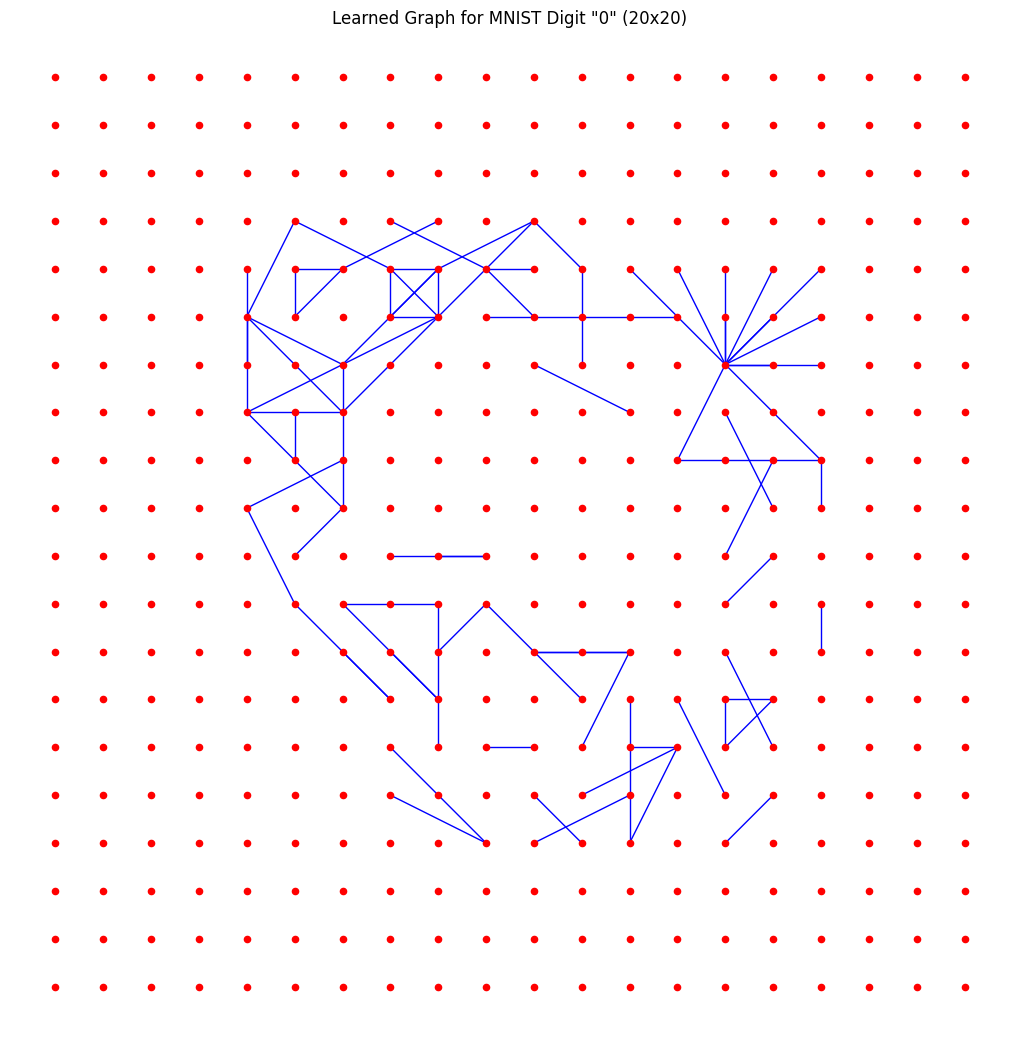

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import fetch_openml
from skimage.transform import resize

# Assuming you have the GLMM function 'awglmm' defined elsewhere
# from your_glmm_module import awglmm

# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1)

# Convert the data and target to NumPy arrays
X = mnist.data.to_numpy().astype(np.float64)
y = mnist.target.astype(int)

# Get indices of digit 0 images
digit_0_indices = np.where(y == 0)[0]

# Extract the first digit 0 image (28x28 pixels)
first_digit_0 = X[digit_0_indices[0]].reshape(28, 28)

# Resize the image to 20x20 pixels
first_digit_0_resized = resize(first_digit_0, (20, 20), anti_aliasing=True).flatten()

# Stack the resized image to create a dataset for the GLMM algorithm
X_digit_0_resized = np.tile(first_digit_0_resized, (500, 1))  # Simulate 500 samples for training

# Apply the GLMM algorithm
iterations = 100
classes = 6
L, gamma_hat, mu, log_likelihood = glmm(X_digit_0_resized, iterations, classes)

print('Training done')
print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))

# Visualize the learned graph
def visualize_learned_graph(L, significant_pixels=None):
    """
    Visualize the learned graph from the Laplacian matrix.
    Only edges between 2-hop neighboring pixels are allowed.
    :param L: The Laplacian matrix learned from GLMM (n x n x classes).
    :param significant_pixels: Optionally pass significant pixel coordinates.
    """
    # L is the Laplacian matrix
    # Compute the adjacency matrix W
    W = np.diag(np.diag(L)) - L

    # Threshold the weights for visualization
    threshold = np.percentile(W, 99)
    W_thresholded = np.copy(W)
    W_thresholded[W_thresholded < threshold] = 0

    # Filter edges to allow only 2-hop neighboring pixels
    filtered_W = np.zeros_like(W_thresholded)
    for i in range(20 * 20):
        # Get the row and column coordinates in the 20x20 grid
        row, col = divmod(i, 20)
        # Define the neighbors within 2 hops
        for dr in range(-2, 3):
            for dc in range(-2, 3):
                if 0 <= row + dr < 20 and 0 <= col + dc < 20:
                    j = (row + dr) * 20 + (col + dc)
                    filtered_W[i, j] = W_thresholded[i, j]
    
    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(filtered_W)

    # Define positions for the nodes (20x20 grid layout)
    positions = {i: (i % 20, i // 20) for i in range(20 * 20)}

    # Visualize the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos=positions, node_size=20, node_color='red', edge_color='blue', with_labels=False)
    plt.title('Learned Graph for MNIST Digit "0" (20x20)')
    plt.axis('off')
    plt.show()

# Visualize the learned graph for the first class
visualize_learned_graph(L[:, :, 0])


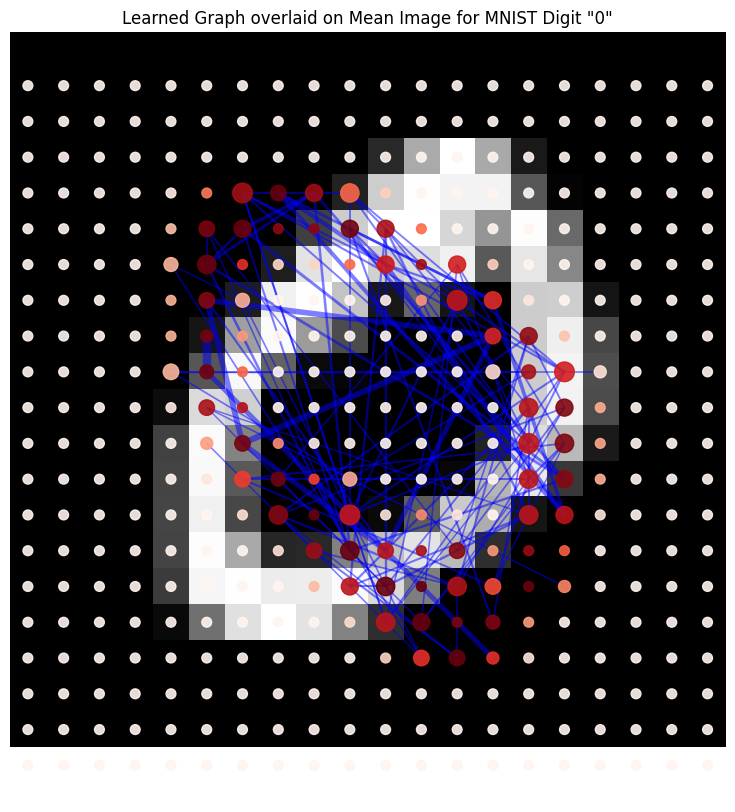

In [149]:
def visualize_learned_graph(L, mu, num_edges=500):
    """
    Visualize the learned graph from the Laplacian matrix L and the mean image mu.
    Overlay the graph on the mean image to visualize the digit as a graph.

    Parameters:
    -----------
    L : np.ndarray
        The Laplacian matrix learned from GLMM (n x n).
    mu : np.ndarray
        The mean image of the digit (n,).
    num_edges : int
        The number of top edges to keep for visualization.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    from matplotlib.colors import Normalize

    n = L.shape[0]
    side = int(np.sqrt(n))  # Assuming square images

    # Compute the adjacency matrix W
    W = np.diag(np.diag(L)) - L

    # Get upper triangle indices
    triu_indices = np.triu_indices(n, k=1)

    # Get edge weights
    W_values = W[triu_indices]

    # Get indices of the top num_edges edges
    sorted_indices = np.argsort(W_values)[::-1]
    top_indices = sorted_indices[:num_edges]
    selected_edges = [(triu_indices[0][i], triu_indices[1][i], W_values[i]) for i in top_indices if W_values[i] > 0]

    # Create the graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_weighted_edges_from(selected_edges)

    # Define positions for the nodes (side x side grid layout)
    positions = {i: (i % side, side - (i // side)) for i in range(n)}  # Flip y-axis for image orientation

    # Get node colors from mu
    node_colors = mu - np.min(mu)  # Normalize to [0, 1]
    node_colors = node_colors / np.max(node_colors)

    # Map node_colors to a colormap
    cmap = plt.cm.Reds

    # Get edge weights for visualization
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Normalize weights for plotting
    max_weight = max(edge_weights)
    min_weight = min(edge_weights)
    norm_weights = [(w - min_weight) / (max_weight - min_weight) for w in edge_weights]
    # Map weights to edge widths
    edge_widths = [1 + 5 * w for w in norm_weights]  # Scale up for visibility

    # Get node degrees for node sizes
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees.values() else 1
    min_degree = min(degrees.values()) if degrees.values() else 0
    node_sizes = [50 + 150 * (degrees.get(n, 0) - min_degree) / (max_degree - min_degree + 1e-5) for n in G.nodes()]

    # Prepare figure
    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    
    # Plot the mean image in grayscale
    mean_image = mu.reshape((side, side))
    plt.imshow(mean_image, cmap='gray', interpolation='nearest')

    # Draw the edges
    nx.draw_networkx_edges(G, pos=positions, width=edge_widths, edge_color='blue', alpha=0.5)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos=positions, node_size=node_sizes, node_color=node_colors, cmap=cmap, alpha=0.9)

    plt.title('Learned Graph overlaid on Mean Image for MNIST Digit "0"')
    plt.axis('off')
    plt.show()

visualize_learned_graph(L[:, :, 5], mu[:, 5], num_edges=100)

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import fetch_openml
from skimage.transform import resize
from scipy.stats import multivariate_normal as mvnpdf


# Visualization Function (improved)
def visualize_learned_graph(L, mu, num_edges=500):
    """
    Visualize the learned graph from the Laplacian matrix L and the mean image mu.
    Overlay the graph on the mean image to visualize the digit as a graph.
    
    Parameters:
    -----------
    L : np.ndarray
        The Laplacian matrix learned from GLMM (n x n).
    mu : np.ndarray
        The mean image of the digit (n,).
    num_edges : int
        The number of top edges to keep for visualization.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    from matplotlib.colors import Normalize

    n = L.shape[0]
    side = int(np.sqrt(n))  # Assuming square images

    # Compute the adjacency matrix W
    W = np.diag(np.diag(L)) - L

    # Get upper triangle indices
    triu_indices = np.triu_indices(n, k=1)

    # Get edge weights
    W_values = W[triu_indices]

    # Get indices of the top num_edges edges
    sorted_indices = np.argsort(W_values)[::-1]
    top_indices = sorted_indices[:num_edges]
    selected_edges = [(triu_indices[0][i], triu_indices[1][i], W_values[i]) for i in top_indices if W_values[i] > 0]

    # Create the graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_weighted_edges_from(selected_edges)

    # Define positions for the nodes (side x side grid layout)
    positions = {i: (i % side, side - (i // side)) for i in range(n)}  # Flip y-axis for image orientation

    # Get node colors from mu
    node_colors = mu - np.min(mu)  # Normalize to [0, 1]
    node_colors = node_colors / np.max(node_colors)

    # Map node_colors to a colormap
    cmap = plt.cm.Reds

    # Get edge weights for visualization
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Normalize weights for plotting
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0
    norm_weights = [(w - min_weight) / (max_weight - min_weight + 1e-5) for w in edge_weights]
    # Map weights to edge widths
    edge_widths = [1 + 5 * w for w in norm_weights]  # Scale up for visibility

    # Get node degrees for node sizes
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees.values() else 1
    min_degree = min(degrees.values()) if degrees.values() else 0
    node_sizes = [50 + 150 * (degrees.get(n, 0) - min_degree) / (max_degree - min_degree + 1e-5) for n in G.nodes()]

    # Prepare figure
    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    
    # Plot the mean image in grayscale
    mean_image = mu.reshape((side, side))
    plt.imshow(mean_image, cmap='gray', interpolation='nearest')

    # Draw the edges
    nx.draw_networkx_edges(G, pos=positions, width=edge_widths, edge_color='blue', alpha=0.5)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos=positions, node_size=node_sizes, node_color=node_colors, cmap=cmap, alpha=0.9)

    plt.title('Learned Graph overlaid on Mean Image')
    plt.axis('off')
    plt.show()

# Main function to process any digit
def process_digit(digit, num_samples=500, image_size=(20, 20), iterations=100, classes=6):
    """
    Processes a specified MNIST digit using GLMM and visualizes the learned graph.
    
    Parameters:
    -----------
    digit : int
        The digit to process (0-9).
    num_samples : int
        Number of samples to use for training.
    image_size : tuple
        The size to which each image will be resized.
    iterations : int
        Number of iterations for the GLMM algorithm.
    classes : int
        Number of clusters (classes) for GLMM.
    """
    # Fetch MNIST data
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    
    # Convert the data and target to NumPy arrays
    X = mnist['data'].astype(np.float64)
    y = mnist['target'].astype(int)
    
    # Get indices of the specified digit images
    digit_indices = np.where(y == digit)[0]
    
    # If num_samples is more than available samples, adjust it
    num_samples = min(num_samples, len(digit_indices))
    
    # Extract the digit images
    digit_images = X[digit_indices[:num_samples]]
    
    # Resize images and flatten
    resized_images = np.array([resize(img.reshape(28, 28), image_size, anti_aliasing=True).flatten() for img in digit_images])
    
    # Stack the resized images to create a dataset for the GLMM algorithm
    X_resized = resized_images  # Shape: (num_samples, image_size[0] * image_size[1])
    
    # Apply the GLMM algorithm
    L, gamma_hat, mu, log_likelihood = glmm(X_resized, iterations, classes)
    
    print(f'Training done for digit "{digit}"')
    print('Sum of gamma_hat:', np.sum(gamma_hat, axis=0))
    
    # Visualize the learned graph for the first class
    visualize_learned_graph(L[:, :, 0], mu[:, 0], num_edges=500)

# Example usage:
# Process digit 3
process_digit(digit=3)


ValueError: cannot reshape array of size 784 into shape (20,20)

In [73]:
# import numpy as np
# from numpy.linalg import inv
# from scipy.stats import multivariate_normal
# from scipy.spatial.distance import pdist
# from scipy.spatial.distance import squareform

# def gsp_distanz(X):
#     # Computes pairwise Euclidean distances between columns of X
#     return pdist(X.T, 'euclidean')

# def glmm(y, iterations, classes, spread=0.1, regul=0.15, norm_par=1.5):
#     """
#     Implements a Graph Laplacian Mixture Model (GLMM)
    
#     Parameters:
#     -----------
#     y : np.ndarray
#         The input data matrix of shape (m, n) where m is the number of signals
#         and n is the number of features.
    
#     iterations : int
#         The number of iterations for the algorithm.
    
#     classes : int
#         The number of clusters (classes).
    
#     spread : float, optional
#         Spread parameter for initializing the Laplacian matrices (default: 0.1).
    
#     regul : float, optional
#         Regularization parameter for the covariance matrices (default: 0.15).
    
#     norm_par : float, optional
#         Normalization parameter for the distance computation (default: 1.5).
    
#     Returns:
#     --------
#     L : np.ndarray
#         The learned Laplacian matrices of shape (n, n, classes).
    
#     gamma_hat : np.ndarray
#         The cluster probabilities of shape (m, classes).
    
#     mu : np.ndarray
#         The cluster means of shape (n, classes).
    
#     log_likelihood : np.ndarray
#         The log-likelihood values over the iterations.
#     """
#     delta = 2
#     n = y.shape[1]
#     m = y.shape[0]
    
#     # Initialize variables
#     L = np.zeros((n, n, classes))
#     W = np.zeros((n, n, classes))
#     sigma = np.zeros((n - 1, n - 1, classes))
#     mu = np.zeros((n, classes))
#     gamma_hat = np.zeros((m, classes))
#     p = np.zeros(classes)
#     vecl = np.zeros((n, n, classes))
#     vall = np.zeros((n, n, classes))
#     yl = np.zeros((m, n - 1, classes))
#     log_likelihood = np.zeros(iterations)
    
#     for cls in range(classes):
#         L[:, :, cls] = spread * np.eye(n) - spread / n * np.ones((n, n))
#         mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
#         mu[:, cls] = mu_curr - np.mean(mu_curr)
#         p[cls] = 1 / classes
    
#     # Start the algorithm
#     for it in range(iterations):
#         # Expectation step
#         pall = np.zeros(m)
#         for cls in range(classes):
#             # Ensure L is symmetric
#             if not np.allclose(L[:, :, cls], L[:, :, cls].T, atol=1e-8):
#                 L[:, :, cls] = (L[:, :, cls] + L[:, :, cls].T) / 2

#             # Check for NaNs and Infs in L
#             if np.isnan(L[:, :, cls]).any() or np.isinf(L[:, :, cls]).any():
#                 print(f'Iteration {it}, Class {cls}: L contains NaNs or Infs')
#                 print(L[:, :, cls])
#                 raise ValueError('L contains NaNs or Infs')

#             # Eigenvalue decomposition
#             try:
#                 eig_vals, eig_vecs = np.linalg.eigh(L[:, :, cls])
#             except np.linalg.LinAlgError as e:
#                 print(f'Iteration {it}, Class {cls}: Eigenvalue decomposition failed')
#                 print(f'Error: {e}')
#                 print('L matrix:')
#                 print(L[:, :, cls])
#                 raise

#             eig_vals = np.real(eig_vals)
#             eig_vecs = np.real(eig_vecs)

#             # Enforce non-negative eigenvalues
#             eig_vals[eig_vals < 1e-5] = 1e-5  # Ensure positive definiteness

#             vecl[:, :, cls] = eig_vecs
#             vall[:, :, cls] = np.diag(eig_vals)

#             # Compute sigma
#             sigma[:, :, cls] = inv(np.diag(eig_vals[1:]) + regul * np.eye(n - 1))
#             sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2  # Ensure symmetry

#             # Compute yl
#             yl[:, :, cls] = (y - mu[:, cls].T) @ eig_vecs[:, 1:]

#             # Compute pall
#             pall += p[cls] * multivariate_normal.pdf(yl[:, :, cls], mean=np.zeros(n - 1), cov=sigma[:, :, cls])
    
#         # Compute cluster probabilities gamma_hat
#         pall[pall == 0] = 1e-10  # Avoid division by zero
#         for cls in range(classes):
#             gamma_hat[:, cls] = (p[cls] * multivariate_normal.pdf(yl[:, :, cls], mean=np.zeros(n - 1), cov=sigma[:, :, cls])) / pall
    
#         log_likelihood[it] = np.sum(np.log(pall))
    
#         # Maximization step: update mu, W, and p
#         for cls in range(classes):
#             gamma_sum = np.sum(gamma_hat[:, cls])
#             mu[:, cls] = (gamma_hat[:, cls].T @ y) / gamma_sum
#             yc = np.sqrt(gamma_hat[:, cls])[:, np.newaxis] * (y - mu[:, cls].T)
#             # Compute pairwise distances between features (columns of yc)
#             Z = gsp_distanz(yc) ** 2  # Z is in condensed form
#             theta = np.mean(Z) / norm_par
#             # Call gsp_learn_graph_log_degrees and unpack the returned tuple
#             W_temp, _ = gsp_learn_graph_log_degrees(Z / theta, 1, 1)
#             # Multiply by delta
#             W_temp = delta * W_temp
#             # Convert W_temp from condensed form to square form
#             W_curr = squareform_sp(W_temp)
#             # Clean up zeros
#             W_curr[W_curr < 1e-3] = 0
#             W[:, :, cls] = W_curr
#             p[cls] = gamma_sum / m
#             # Compute Ls
#             L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]
    
#     return L, gamma_hat, mu, log_likelihood


In [ ]:

# def squareform_sp(w):
#     """
#     Sparse counterpart of numpy's squareform
    
#     Parameters:
#     w : sparse vector with n(n-1)/2 elements OR matrix with size [n, n] and zero diagonal
    
#     Returns:
#     W : matrix form of input vector w OR vector form of input matrix W
#     """
    
#     # If input is not sparse, it doesn't make sense to use this function
#     if not sp.issparse(w) and w.nnz / w.size > 1/10:
#         raise ValueError("Use standard squareform for non-sparse vector!")
    
#     if w.shape[0] == 1 or w.shape[1] == 1:  # It's a vector
#         # VECTOR -> MATRIX
#         l = w.shape[0] if w.shape[1] == 1 else w.shape[1]
#         n = int(round((1 + np.sqrt(1 + 8*l)) / 2))
        
#         # Check input
#         if l != n*(n-1)//2:
#             raise ValueError("Bad vector size!")
        
#         ind_vec, s = w.nonzero()[1] if w.shape[0] == 1 else w.nonzero()[0], w.data
#         num_nz = len(ind_vec)
        
#         # Indices inside the matrix
#         ind_i, ind_j = np.zeros(num_nz, dtype=int), np.zeros(num_nz, dtype=int)
        
#         k = 0
#         for i in range(n-1):
#             for j in range(i+1, n):
#                 if k < num_nz and ind_vec[k] == k:
#                     ind_i[k] = i
#                     ind_j[k] = j
#                     k += 1
        
#         # For the lower triangular part just add the transposed matrix
#         return sp.csr_matrix((np.concatenate([s, s]), 
#                               (np.concatenate([ind_i, ind_j]), np.concatenate([ind_j, ind_i]))), 
#                              shape=(n, n))
    
#     else:  # It's a matrix
#         # MATRIX -> VECTOR
#         m, n = w.shape
#         if m != n or not np.all(w.diagonal() == 0):
#             raise ValueError("Matrix has to be square with zero diagonal!")
        
#         ind_i, ind_j = w.nonzero()
#         s = w.data
        
#         # Keep only upper triangular part
#         ind_upper = ind_i < ind_j
#         ind_i, ind_j, s = ind_i[ind_upper], ind_j[ind_upper], s[ind_upper]
        
#         # Compute new (vector) index from (i,j) (matrix) indices
#         new_ind = (n*ind_i - ind_i*(ind_i+1)//2 + ind_j - ind_i - 1).astype(int)
        
#         return sp.csr_matrix((s, (new_ind, np.zeros_like(new_ind))), 
#                              shape=(n*(n-1)//2, 1))



# def normest(S, tol=1e-6, maxiter=100):
#     n = S.shape[1]
#     x = np.random.rand(n)
#     x /= np.linalg.norm(x)
#     norm = None
#     for _ in range(maxiter):
#         x_old = x.copy()
#         x = S.transpose().dot(S.dot(x))
#         norm = np.linalg.norm(x)
#         x /= norm
#         if np.linalg.norm(x - x_old) < tol:
#             break
#     return np.sqrt(norm)

# def generate_connected_graph(n, p, zero_thresh):
#     """
#     Generates a connected Erdos-Renyi graph and returns its Laplacian matrix.

#     Parameters:
#     -----------
#     n : int
#         Number of nodes in the graph.
    
#     p : float
#         Probability for edge creation in the Erdos-Renyi graph.
    
#     zero_thresh : float
#         Threshold for the second smallest eigenvalue of the Laplacian matrix
#         to ensure graph connectivity.

#     Returns:
#     --------
#     np.ndarray
#         Laplacian matrix of the generated connected graph.
#     """
#     while True:
#         g = nx.erdos_renyi_graph(n, p)
#         L = nx.laplacian_matrix(g).toarray()
#         eigs = np.sort(eigvals(L))
#         if eigs[1] > zero_thresh:
#             return L





# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix.
    
#     a : float
#         Coefficient for the logarithmic penalty term.
    
#     b : float
#         Regularization coefficient.
    
#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)
#         - 'c': float, regularization coefficient for initial weight matrix

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     if params is None:
#         params = {}

#     # Default parameters
#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z
#     else:
#         z = squareform(Z)

#     z = z.flatten().astype(np.float64) 
#     l = len(z)
#     n = round((1 + np.sqrt(1 + 8 * l)) / 2)  # number of nodes

#     if w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params.w_0 is specified, params.c should also be specified')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0
#         else:
#             w_0 = squareform(w_0)
#         w_0 = w_0.flatten().astype(np.float64) 
#     else:
#         w_0 = 0

#     if fix_zeros:
#         if isinstance(params['edge_mask'], np.ndarray) and params['edge_mask'].ndim == 1:
#             edge_mask = params['edge_mask']
#         else:
#             edge_mask = squareform(params['edge_mask'])
#         ind = np.where(edge_mask.flatten() > 0)[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     z=np.asarray(z)
#     w_0 = np.asarray(w_0)
#     w = np.zeros_like(z)

#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = normest(S)
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     f_eval = lambda w: 2 * np.dot(w.T, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda z: -a * np.sum(np.log(np.clip(z, 1e-10, None))) # Avoid log(0)
#     g_prox = lambda z, c: prox_sum_log(np.clip(z, 1e-10, None), c * a, param_prox_log)[0]  # Avoid log(0) in prox
#     g_star_prox = lambda z, c: z - c * a * g_prox(z / (c * a), 1 / (c * a))

#     if np.all(w_0 == 0):
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2
#         h_grad = lambda w: 2 * b * w
#         h_beta = 2 * b
#     else:
#         h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0,'fro') ** 2
#         h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
#         h_beta = 2 * (b + c)

#     mu = h_beta + norm_K
#     epsilon = lin_map(0.0, [0, 1 / (1 + mu)], [0, 1])
#     gn = lin_map(step_size, [epsilon, (1 - epsilon) / mu], [0, 1])

#     v_n = K_op(w)
#     stat = {
#         'f_eval': np.full(maxit, np.nan),
#         'g_eval': np.full(maxit, np.nan),
#         'h_eval': np.full(maxit, np.nan),
#         'fgh_eval': np.full(maxit, np.nan),
#         'pos_violation': np.full(maxit, np.nan),
#         'time': 0
#     }

#     start_time = time.time()

#     for i in range(maxit):
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         stat['f_eval'][i] = f_eval(w)
#         stat['g_eval'][i] = g_eval(K_op(w))
#         stat['h_eval'][i] = h_eval(w)
#         stat['fgh_eval'][i] = stat['f_eval'][i] + stat['g_eval'][i] + stat['h_eval'][i]
#         stat['pos_violation'][i] = -np.sum(np.minimum(0, w))

#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)  # Avoid divide by zero
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)  # Avoid divide by zero

#         if verbosity > 1:
#             print(f'iter {i:4d}: {rel_norm_primal:6.4e} {rel_norm_dual:6.4e}')

#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     stat['time'] = time.time() - start_time

#     if verbosity > 0:
#         print(f'# iters: {i:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e} OBJ {f_eval(w) + g_eval(K_op(w)) + h_eval(w):6.3e}')
#         print(f'Time needed is {stat["time"]} seconds')

#     if fix_zeros:
#         w = np.array([w[ind]])

#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform(w)

#     return W




# def graph_learning_perf_eval(L_0, L):
#     """
#     Evaluates the performance of a learned graph by comparing it with the ground truth Laplacian matrix.

#     Parameters:
#     -----------
#     L_0 : np.ndarray
#         Ground truth Laplacian matrix of shape (n, n).
    
#     L : np.ndarray
#         Learned Laplacian matrix of shape (n, n).

#     Returns:
#     --------
#     precision : float
#         Precision score of the learned graph.
    
#     recall : float
#         Recall score of the learned graph.
    
#     f : float
#         F1 score of the learned graph.
    
#     NMI_score : float
#         Normalized Mutual Information score of the learned graph.
    
#     num_of_edges : int
#         Number of edges in the learned graph.
#     """
#     # Edges in the ground truth graph
#     L_0tmp = L_0 - np.diag(np.diag(L_0))
#     L_0tmp = (L_0tmp + L_0tmp.T) / 2  
#     edges_groundtruth = squareform(L_0tmp) != 0

#     # Edges in the learned graph
#     Ltmp = L - np.diag(np.diag(L))
#     Ltmp = (Ltmp + Ltmp.T) / 2  
#     edges_learned = squareform(Ltmp) != 0

#     # Recall & precision
#     precision, recall, _ = precision_recall_curve(edges_groundtruth.astype(int), edges_learned.astype(int))
#     precision = precision[1] if len(precision) > 1 else 0
#     recall = recall[1] if len(recall) > 1 else 0

#     # F-measure
#     if precision + recall == 0:
#         f = 0
#     else:
#         f = 2 * precision * recall / (precision + recall)

#     # NMI
#     NMI_score = nmi(edges_learned.astype(int), edges_groundtruth.astype(int))
#     if np.isnan(NMI_score):
#         NMI_score = 0

#     # Number of edges in the learned graph
#     num_of_edges = np.sum(edges_learned)

#     return precision, recall, f, NMI_score, num_of_edges



# def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
#     """
#     Identifies and compares clusters based on given Laplacian matrices and cluster assignments.

#     Parameters:
#     -----------
#     Ls : np.ndarray
#         Estimated Laplacian matrices of shape (n, n, k).
    
#     Lap : np.ndarray
#         Ground truth Laplacian matrices of shape (n, n, k).
    
#     gamma_hats : np.ndarray
#         Estimated cluster assignments of shape (m, k).
    
#     gamma_cut : np.ndarray
#         Ground truth cluster assignments of shape (m, k).
    
#     k : int
#         Number of clusters.

#     Returns:
#     --------
#     identify : np.ndarray
#         Indices of the identified clusters of shape (k,).
    
#     precision : np.ndarray
#         Precision scores for each cluster of shape (k,).
    
#     recall : np.ndarray
#         Recall scores for each cluster of shape (k,).
    
#     f : np.ndarray
#         F1 scores for each cluster of shape (k,).
    
#     cl_errors : np.ndarray
#         Clustering errors for each cluster of shape (k,).
    
#     NMI_score : np.ndarray
#         Normalized Mutual Information scores for each cluster of shape (k,).
    
#     num_of_edges : np.ndarray
#         Number of edges for each cluster of shape (k,).
#     """
#     identify = np.zeros(k, dtype=int)
#     cl_err = np.inf * np.ones(k)
#     precision = np.zeros(k)
#     recall = np.zeros(k)
#     f = np.zeros(k)
#     NMI_score = np.zeros(k)
#     num_of_edges = np.zeros(k)

#     for i in range(k):
#         W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
#         W[W < 0.001] = 0
#         Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
#         for j in range(k):
#             er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j])
#             if cl_err[i] > er:
#                 cl_err[i] = er
#                 identify[i] = j

#     for i in range(k):
#         precision[i], recall[i], f[i], NMI_score[i], num_of_edges[i] = graph_learning_perf_eval(Lap[:, :, identify[i]], Ls[:, :, i])

#     cl_errors = np.diag((gamma_hats - gamma_cut[:, identify]).T @ (gamma_hats - gamma_cut[:, identify]))

#     return identify, precision, recall, f, cl_errors, NMI_score, num_of_edges